# 04. Preprocessing Racing Bib Numbers (RBNR) Dataset

### Purpose:
Create augmented images with annotations for the RBNR dataset, and then convert the annotations to the Darknet TXT format.

### Before Running Notebook:
1. Install the imgaug library for data augmentation.  Augmentation code adapted from the imgaug docs [here](https://imgaug.readthedocs.io/en/latest/source/examples_bounding_boxes.html).
1. Download the RBNR datasets from [here](https://people.csail.mit.edu/talidekel/RBNR.html).
1. Move the `set1_org`, `set2_org`, and `set3_org` folders into ./Data/RBNR/ relative to the top level of this repo.
1. The relative path from this notebook to the set1 and set2 folders must be assigned to the input_path variables under the Execute Augmentation heading.
1. Create a folder also in RBNR to save the augmented images and make sure the relative path points to this location under Execute Augmentation (currently augmented_noFlip).
1. The `.mat` files for each image must be included in the same directory as the image that it describes.

### Details:
The annotations for the RBNR dataset are provided as Matlab formatted files named `<image name>.mat`.  There is one file for each image.  A description of the format can be found in the `readme.txt` located in each set folder.  In this project, I will be using Darknet to train custom Yolo models with this dataset, and Darknet requires annotations to be in the Darknet TXT format.  

More information about Darknet annotation format can be found [here](https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects).

In [1]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

import scipy.io as sio
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_bbox_obj(path, img_name, shape):
    """
    Get RBNR bounding box info for a given image.
    
    Args
        path (str): path to image directory
        img_name (str): image name
        shape: (width, height) of image
        
    Returns
        Bounding Boxes object containing all boxes for image in the format
        (x1, y1, x2, y2)
    """
    # load annotation file
    f = sio.loadmat(path + img_name + '.mat')
    
    # get bounding values
    boxes = f['tagp']
    # create bounding boxes object
    bbs = BoundingBoxesOnImage([
        BoundingBox(x1=box[2], y1=box[0], x2=box[3], y2=box[1]) for box in boxes
    ], shape=shape)
    
    return bbs

In [3]:
def augment(images, bbs):
    """
    Apply random agumentations to a list of images and bounding boxes.
    
    Args
        images (list of numpy arrays): list of images from openCV .imread
        bbs (list of BoundingBoxesOnImage): list bounding box objects
        
    Returns
        augmented images and bounding boxes in separate lists
    """
    seq = iaa.Sequential([
        #iaa.Fliplr(0.5), # horizontal flips
        iaa.Crop(percent=(0, 0.1)), # random crops
        # Small gaussian blur with random sigma between 0 and 0.5.
        # But we only blur about 50% of all images.
        iaa.Sometimes(
            0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        # Strengthen or weaken the contrast in each image.
        iaa.LinearContrast((0.75, 1.5)),
        # Add gaussian noise.
        # For 50% of all images, we sample the noise once per pixel.
        # For the other 50% of all images, we sample the noise per pixel AND
        # channel. This can change the color (not only brightness) of the
        # pixels.
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        # Make some images brighter and some darker.
        # In 20% of all cases, we sample the multiplier once per channel,
        # which can end up changing the color of the images.
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        # Apply affine transformations to each image.
        # Scale/zoom them, translate/move them, rotate them and shear them.
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8)
        )
    ], random_order=True) # apply augmenters in random order
    
    return seq(images=images, bounding_boxes=bbs)

In [4]:
def create_annot_file(bbs, img, img_name, path):
    """
    Create a single Darknet TXT annotation file for an image.
    Writes to file <image name>.txt in same directory as image.

    Args
        bbs (BoudningBoxesOnImage): bounding boxes object for the image
        img (numpy array): image as numpy array from openCV .imread
        img_name (str): name of image
        path (str): path to image directory
        
    Returns
        None
    """
    
    # get dimensions of image
    (h_img, w_img) = img.shape[:2]
        
    # initialize list for annotations
    annots = []
    
    for i in range(len(bbs.bounding_boxes)):
        box = bbs.bounding_boxes[i]
        # get original bounding values
        (x, y) = (box.x1, box.y1)
        (w, h) = (box.x2 - box.x1, box.y2 - box.y1 )

        # transform x and y
        centerX = x + (w / 2)
        centerY = y + (h / 2)

        # normalize bounding values
        centerX /= w_img
        centerY /= h_img
        w /= w_img
        h /= h_img

        # append annotation in Darknet format to annotation list
        annots.append(f'{0} {centerX} {centerY} {w} {h}\n' )
    
    # write annotations to file 
    annot_file = open(path + img_name.split('.')[0] + '.txt', 'w')
    annot_file.writelines(annots)
    annot_file.close()

In [5]:
def create_augmented_images(num, input_path, img_name, output_path):
    """
    Create a given number of augmented images with bounding boxes given an
    original image.
    
    Args
        num (int): number of augmented images to create
        input_path (str): path to original image directory
        img_name (str): name of original image
        output_path (str): directory for saving augmented images and bounding
                           box files
                            
    Returns
        None
    """
    
    # Duplicate image and resize
    # This size is the size of the YOLO model input
    images = [cv.imread(input_path + img_name) for _ in range(num)]

    # bring in bounding boxes
    bbs_list = [get_bbox_obj(input_path, img_name, images[0].shape) for _ in range(num)]
    
    # augment
    images_aug, bbs_aug = augment(images, bbs_list)
    
    # save augmented images and bounding boxes
    for i, img in enumerate(images_aug):
        img_filename = img_name[:-4] + '_' + str(i+1) + '.JPG'
        cv.imwrite(output_path + img_filename, img)
        boxes = bbs_aug[i].remove_out_of_image().clip_out_of_image()
        create_annot_file(boxes, img, img_filename, output_path)
        

# Execute Augmentation
---

In [7]:
# RBNR Set1
num = 32 # number of augmented images per original
input_path = '../Data/RBNR/set1_org/'
output_path = '../Data/RBNR/augmented_noFlip/'

for image_name in os.listdir(input_path):
    if image_name.endswith('.JPG'):
        create_augmented_images(num, input_path, image_name, output_path)

In [8]:
# RBNR Set2
num = 32 # number of augmented images per original
input_path = '../Data/RBNR/set2_org/'
output_path = '../Data/RBNR/augmented_noFlip/'

for image_name in os.listdir(input_path):
    if image_name.endswith('.JPG'):
        create_augmented_images(num, input_path, image_name, output_path)

# Test Annotation File
---

In [126]:
def darknet_to_standard(path, f_name, img):
    """
    Read in bounding box values for an image from Darknet formated annotation
    file, and convert for drawing on image.
    
    Args
        path (str): path to directory of image
        f_name (str): name of image file
        img (numpy array): image array from openCV .imread
        
    Returns:
        list of bounding boxes for image as [x, y, width, height]
    """
    
    # get original image dimension
    (h_img, w_img) = img.shape[:2]
    
    #read in bounding box from Darknet file
    f = open(path + f_name)
    objects = f.readlines()
    
    boxes = []
    for obj in objects:
        # get bounding box values
        box = [float(i) for i in obj.strip().split()[1:]]
        # convert from normalized to original size
        sized_box = box * np.array([w_img, h_img, w_img, h_img])
        # convert x and y from center to corner
        (centerX, centerY, width, height) = sized_box.astype("int")
        x = int(centerX - (width / 2))
        y = int(centerY - (height / 2))
        # reconfigure and save to list
        orig_box = [x, y, int(width), int(height)]
        boxes.append(orig_box)
    
    return boxes

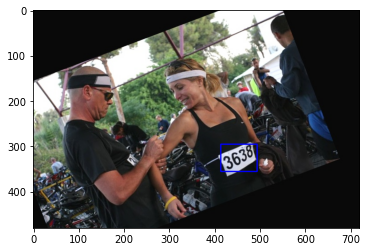

In [143]:
# set path and annotation file name
path = '../Data/RBNR/augmented/'
f_name = 'set1_01_15.txt'

# open the image
img = cv.imread(path + f_name[:-4] + '.JPG')

# get all bounding boxes for the image
boxes = darknet_to_standard(path, f_name, img)

# mark boxes on image
for (x, y, w, h) in boxes:
    img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# display image
RGB_im = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(RGB_im)